# Playing Punish with Reinforcement Learning
### Jim Shepich III
### Updated: 10 October 2022
### Time Required: 23 hours 33  minutes

# Contents <a id="contents"></a>

- [Import Packages](#import-packages)
- [Notebook Settings](#config)
- [Representing Game States](#states)
- [Representing Actions](#actions)
- [Simulating the Game Environment](#environment)
- [Enumerating State Space](#state-space)
- [Modeling Enemy Strategies](#enemy-strategies)
    - [Summary of Empirical Strategic Data](#data-summary)
    - [Possible Actions Reweighted by Limited Empirical Strategic Samples (PARLESS)](#parless)
    - [PARLESS Augmented With Neural Networks (PAWNN)](#pawnn)
- [Enumerating State-Action Transition Probabilities](#transitions)
    - [Naïve Transition Probabilities](#naive-transitions)
- [Implementation of Value Iteration](#value-iteration)
- [Agent Training](#training)
    - [Naïve Agent](#naive-agent)

# Import Packages <a name="import-packages"></a>
### [↑ Contents](#contents)

In [110]:
using Combinatorics
using StatsBase
using Random
using JSON
using BenchmarkTools
using Plots; gr()
using StatsPlots
using WebIO
using SQLite
using DataFrames

# Notebook Settings <a name="config"></a>
### [↑ Contents](#contents)

This section allows a user to configure the setttings of this notebook. For the most part, it will allow you to toggle between generating results or loading them from a file on disk, as well as set model hyperparameters.

In [66]:
CONFIG = Dict(
    "state-space" => Dict(
        "generate" => false,
        "filepath" => "statespace.json"
    ),
    "training-cutoff" => 1668358800,
    #Specifies the last game ID used for training 
    #(use to ensure analysis of training data is accurate).
    "transition-probabilities" => Dict(
        "naive" => Dict("generate"=>false,"filepath"=>"naive_transitions.json"),
        "parless" => Dict("generate"=>true,"filepath"=>"parless_transitions.json"),
        "pawnn" => Dict("generate"=>true,"filepath"=>"pawnn_transitions.json")
    ),
    "value-iteration" => Dict(
        "naive" => Dict("generate"=>false,"episodes"=>0,"filepath"=>"q_naive.json")
    )
)

Dict{String, Any} with 4 entries:
  "value-iteration"          => Dict{String, Dict{String, Any}}("naive"=>Dict("…
  "transition-probabilities" => Dict{String, Dict{String, Any}}("naive"=>Dict("…
  "state-space"              => Dict{String, Any}("generate"=>false, "filepath"…
  "training-cutoff"          => 1668358800

JSON only allows keys to be strings. This is a bit of a problem, since our transition probability maps and state-action value functions are nested dictionaries with integer keys. Rather than converting encoded states and actions to strings when performing lookups, which will be an inefficiency that really adds up, we'll just create a recursive function to parse the keys of these JSON-serialized dictionaries as integers.

In [3]:
function strkeys2int(d::Dict{String,Any})
    """This is a function that recursively converts the keys of a `Dict{String,Any}`
    and its nested `Dict{String,Any}` values into `Int64` data."""
    return Dict(parse(Int64,key)=>strkeys2int(value) for (key,value) in d)
    #Parse all keys as integers and then call this function on the value.
    #If the value is a `Dict{String,Any}`, then its keys will be converted too;
    #if not, the value will be left alone.
end

function strkeys2int(value::Any)
    return value
end

strkeys2int (generic function with 2 methods)

In [4]:
training_log = JSON.parsefile("training_log.json",use_mmap=false)

Dict{String, Any} with 1 entry:
  "naive" => Any[675.507, 695.864, 699.245, 694.724, 676.924, 653.037, 631.188,…

# Representing Game States <a id="states"></a>
### [↑ Contents](#contents)

In a standard, two-player game of Punish, the game state consists of the following attributes:

- The cards in the two players' hands
- The cards that are showing (cards that have been played and the two cards that have been revealed)
- The cards that are face-down in the deck (which can potentially be played via the Feint action)
- Whether or not each player has already feinted
- Whether or not each player is exhausted from using the Punish action
- Both players' HP totals
- The breath number 

Although the measure number is also an aspect of the game state, we will exclude it from our modeling because although measure number may have an impact on how a player's attitudes toward taking risks evolves, it does not change the mechanics of the game. Because a game of Punish can theoretically last for an indefinite number of measures (much like Rock-Paper-Scissors), it is necessary that we exclude measure number in order to have a finite state space.

We will design our model to support an agent with the limited perspective of a single player. This means that instead of seeing the specific cards in the opponent's hand and the deck, the agent will only be able to see the number of cards in each. Additionally, since the number of face-down cards in the deck can be determined based on feinting status, we don't need to include it in the state. 

In the next cell, we create a custom structure in which to store a game state. For convenience, we will use `NamedTuple` structures to store the number of each card type in the player's hand, the player's status conditions, enemy's status conditions and hand size, and number of each card type in the discard pile. 

Victory and loss states will be singleton structures.

In [5]:
abstract type PunishState end

struct DuelingState <: PunishState
    breath::Int64
    hand::NamedTuple{(:guard, :rush, :dodge, :strike, :punish), NTuple{5, Int64}}
    status::NamedTuple{(:hp, :exhausted, :feinted), Tuple{Int64, Bool, Bool}}
    enemy::NamedTuple{(:hp, :hand_size, :exhausted, :feinted), Tuple{Int64, Int64, Bool, Bool}}
    discard::NamedTuple{(:guard, :rush, :dodge, :strike, :punish), NTuple{5, Int64}}
end 

struct WinState <: PunishState end
struct LossState <: PunishState end

Although a struct with `NamedTuple` fields is convenient to work with, it is not a memory-efficient data structure to use in the state-action value function, which we will represent with a lookup table. So, in the next cell, we will implement functions to encode the game state as an integer and decode a game state from such an integer. We will encode a win as -1 and a loss as -2; all dueling states will be encoded as positive integers.

In [6]:
function encode_state(state::DuelingState)
    """This function encodes a `DuelingState` structure as an integer in which each digit
    corresponds to an attribute of the game state."""
    digit_list = vcat(
        [state.breath],
        [card for card in state.hand],
        [Int(stat) for stat in state.status],
        [Int(stat) for stat in state.enemy],
        [card for card in state.discard]
    )
    #Sequentially add each attribute of the game state to a list of digits.
    return sum([digit*10^(i-1) for (i, digit) in enumerate(reverse(digit_list))])
    #Convert the list of digits into an integer by multiplying each digit by the 
    #next power of 10 and adding them all together. Reverse the array so that
    #the first digit in the array gets multiplied by the largest power of 10
    #and becomes the leftmost digit in the resulting integer.
end

function encode_state(state::WinState)
    return -1
    #Encode a winning state as -1.
end

function encode_state(state::LossState)
     return -2
    #Encode a losing state as -2.
end


function decode_state(coding::Int64)
    """This function decodes a game state that has been
    encoded as an integer and returns a `DuelingState` structure."""
    if coding < 0
        return [WinState(),LossState()][abs(coding)]
    end
    digit_list = reverse(digits(coding))
    #Convert the encoding into an array of digits, and reverse it so
    #that the leftmost digit is the first entry in the array.
    state = DuelingState(
        digit_list[1],
        (
            guard=digit_list[2], 
            rush=digit_list[3], 
            dodge=digit_list[4], 
            strike=digit_list[5], 
            punish=digit_list[6]
        ),
        (
            hp=digit_list[7],
            exhausted=Bool(digit_list[8]),
            feinted=Bool(digit_list[9])
        ),
        (
            hp=digit_list[10], 
            hand_size=digit_list[11],
            exhausted=Bool(digit_list[12]),
            feinted=Bool(digit_list[13])
        ),
        (
            guard=digit_list[14], 
            rush=digit_list[15], 
            dodge=digit_list[16], 
            strike=digit_list[17], 
            punish=digit_list[18]
        )
    )
end

decode_state (generic function with 1 method)

Just in case, we will define a dispatch of the `==` operator to compare a pair of `PunishState`s. Turns out that we can easily compare a pair of `PunishState` objects by comparing their integer encodings.

In [7]:
Base.:(==)(x::PunishState, y::PunishState) = encode_state(x) == encode_state(y)

# Representing Actions <a id="actions"></a>
### [↑ Contents](#contents)

Now, we need to decicde how we will represent actions. There are no more than 10 unique actions that can be taken in the game of Punish: play one of any of the 5 card types, or feint with one of those cards. I think that it will be most convenient to work with actions that are represented as `(card::Symbol, feint::Bool)` pairs. However, for memory efficiency, we will encode these pairs as a two-digit integer in which the first digit identifies the card and the second digit indicates whether or not that card is used for a feint.

Importantly, if a player is exhausted, then they may not take any actions. We will use the `(:rest,:false)` tuple for this "action", which we will encode numerically as `90`.

In [8]:
function encode_action(action::Tuple{Symbol,Bool})
    """This function takes an action represented as a (card, is_feint) tuple and 
    encodes it as an integer in which the first digit represents the card used and
    the second represents whether or not the action is a feint.
    """
    card_identifiers = (guard=1,rush=2,dodge=3,strike=4,punish=5,rest=9)
    #Encode cards as their priority +1; encode a "rest"/the nothing card as a 9.
    return card_identifiers[action[1]]*10+Int(action[2])
end

function decode_action(coding::Int)
    """This function decodes an action encoded as an integer back into a (card,is_feint) tuple."""
    card_identifiers = Dict(1=>:guard,2=>:rush,3=>:dodge,4=>:strike,5=>:punish,9=>:rest)
    card = card_identifiers[digits(coding)[2]]
    feint = Bool(digits(coding)[1])
    return (card,feint)
end

decode_action (generic function with 1 method)

In [9]:
function possible_actions(state::DuelingState)
    """This function returns an encoded list of the possible actions
    that can be taken by the player from a given state."""
    actions = []
    if (state.status.exhausted) || (state.breath==5)
        return [encode_action((:rest,false))]
        #When the player is exhausted, the only action they can take
        #is rest (which by definition does not involve a feint).
        #Use Rest without reint as a sentinel action for intermediary
        #"Breath 5" states.
    end
    
    for (card,count) in pairs(state.hand)
        if count == 0 
            continue
        else
            push!(actions,encode_action((card,false)))
            #The player can play any card that they hold at least 1 of.
            if !state.status.feinted
                push!(actions,encode_action((card,true)))
                #If they have not already feinted this breath, they also 
                #have the option of discarding that card to perform a feint.
            end
        end
    end
    return actions
end

function possible_actions(state::Int)
     return possible_actions(decode_state(state))
end

function possible_actions(state::WinState)
     return [90]
end

function possible_actions(state::LossState)
     return [90]
end
#Use Rest without feint as a sentinel action for Win/Loss states.

possible_actions (generic function with 4 methods)

# Simulating the Game Environment <a id="environment"></a>
### [↑ Contents](#contents)

In this section, we will create the functions that implement our representation of the overall game environment. In RL problems, the environment is typically modeled as a Markov Decision Process (MDP) — a model in which at any state, an agent can choose from some set of actions that will influence the probabilities of transitioning to different states, and the set of possible actions and transition probabilities from any given state are fixed. In other words, the actions and transition probabilities are a state function rather than a path function.

Treating PUNISH as an MDP is a bit of an oversimplification because throughout the course of a Measure, you gain information about what is in the opponent's hand. The most clear example is that if you play a Punish against a Dodge and the enemy does not follow up with a Punish, you know that they do not have a Punish in hand. Additionally, if both players feint and do not use Punish until the last measure, you know with certainty the single card that is in the enemy's hand.

Now, if I were to include this information in the game state, there would be less bias in treating the game as an MDP. However, I made the command decision that the benefit of including this information is outweighed by the increase in the size of the state space that would result from it. 

In [10]:
function ΔHP(cards::NamedTuple{(:player,:enemy),Tuple{Symbol,Symbol}})
    """This function computes the change in HP incurred by each player
    when a pair of cards is played. Priority is not taken into account here."""
    if cards.player == cards.enemy
        return (player=0, enemy=0)
        #No damage is dealt in a clash. 
    end
    
    damage_map = Dict(:rush=>1,:strike=>2,:punish=>3)
    player_Δ = -get(damage_map,cards.enemy,0) *
        #Base damage.
        (cards.player==:dodge ? cards.enemy==:rush : 1) +
        #Dodging reduces base damage from non-Rush attacks to 0.
        (cards.player==:guard ? Int(cards.enemy in keys(damage_map)) : 0)
        #Guarding reduces damage from any attacks by 1.
    enemy_Δ = -get(damage_map,cards.player,0) *
        #Base damage.
        (cards.enemy==:dodge ? cards.player==:rush : 1) +
        #Dodging reduces base damage from non-Rush attacks to 0.
        (cards.enemy==:guard ? Int(cards.player in keys(damage_map)) : 0)
        #Guarding reduces damage from any attacks by 1.
    
    return (player=player_Δ, enemy=enemy_Δ)
    
end

ΔHP (generic function with 1 method)

In [11]:
priority = Dict(
    :rest => -1,
    :guard => 0,
    :rush => 1,
    :dodge => 2,
    :strike => 3,
    :punish => 4
)

Dict{Symbol, Int64} with 6 entries:
  :strike => 3
  :dodge  => 2
  :guard  => 0
  :punish => 4
  :rest   => -1
  :rush   => 1

Before we continue, there is a quirk we must introduce into our model. After the fourth Breath of a Measure is resolved, if both players remain above 0 HP, the deck and the discard pile are shuffled together and are used to deal both players back up to 5 cards. This means that the successors of a Breath 4 state will be Breath 1 states (and Win/Loss states). 

In later sections, we compute transition probabilities for each (state,action) pair. Due to the overwhelmingly large cardinality of the set of possible Breath 4 states (>100k), we found it to be prohibitively inefficient to compute all possible re-dealings for that many Breath 4 states. To remedy this, we will use intermediary "Breath 5" states to represent game states after the actions taken in a fourth Breath are resolved but before the cards are redealt. Since status effects are cleared and players heal 1 HP (to a max of 3) between Measures, we will apply this in between Breath 4 and Breath 5 states, which will result in a smaller number of possible Breath 5 states over which redealing probabilities must be computed.

In [12]:
function breath(
    state::DuelingState,
    picks::NamedTuple{(:player,:enemy),Tuple{Symbol,Symbol}},
    feints::NamedTuple,
    )
    """This function takes complete information about one Breath (i.e. the input state,
    as well as both players' picked cards and the results of any feints) and returns the
    successor state. 
    
    This function is designed to be deterministic and single-valued. To that end, successors
    of a fourth breath are returned as a single placeholder whose `breath` field is set to 5;
    we will use a different function to compute all possible re-deals for the start of a new
    measure.
    """
    plays = (
        player=isnothing(feints.player) ? picks.player : feints.player, 
        enemy=isnothing(feints.enemy) ? picks.enemy : feints.enemy
    )
    #Track the actual cards that are played 
    #(i.e. if feinting, the drawn card; otherwise, the picked card).
    
    successor = DuelingState(
        state.breath + 1,
        (; [(card,count-Int(card==picks.player)) for (card,count) in pairs(state.hand)]...),
        #Whichever card was picked is removed from the hand.
        (
            hp = state.status.hp+ΔHP(plays).player,
            #Compute the change in HP and apply it to the HP total.
            exhausted = (plays.player==:punish),
            #If the player played Punish this breath they become exhausted.
            feinted = (!isnothing(feints.player)||state.status.feinted)
            #The player has feinted if they feinted this breath or in a previous breath.
        ),
        (
            hp = state.enemy.hp+ΔHP(plays).enemy, 
            hand_size = (state.enemy.hand_size-Int(plays.enemy!=:rest)),
            #The enemy's hand size decreases by 1 unless they rested after a Punish.
            exhausted= (plays.enemy==:punish),
            feinted = (!isnothing(feints.enemy)||state.enemy.feinted)
        ),
        (; [(card,count+sum([picks...,feints...].==card)) 
            for (card,count) in pairs(state.discard)]...),
        #For each card type in the discard pile, increment the count for every
        #pick and every feint that matched that type this breath.  
    )
    
    if successor.status.hp <= 0
        if successor.enemy.hp <= 0
            return priority[plays.player] < priority[plays.enemy] ? WinState() : LossState()
            #If both players would be reduced to nonpositive HP this breath, the winner
            #is determined by card priority.
        else
            return LossState()
            #If just the player would be reduced to nonpositive HP, it is a loss.
        end
    elseif successor.enemy.hp <= 0
        return WinState()
        #If just the enemy would be reduced to nonpositive HP, it is a win.
    else
        if successor.breath == 5
            successor = DuelingState(
                successor.breath,
                successor.hand,
                (hp=min(3,successor.status.hp+1),exhausted=false,feinted=false),
                (hp=min(3,successor.enemy.hp+1),hand_size=successor.enemy.hand_size,exhausted=false,feinted=false),
                successor.discard
            )
            #When entering a Breath 5 state, both players heal 1 HP (to a max of 3),
            #and status effects (feinted/exhausted) are cleared.
        end
        
        return successor
        #If both the player and the enemy have positive HP, then the duel continues.
    end
end

breath (generic function with 1 method)

In [13]:
function redeal(state::DuelingState)
    """This function takes an end-of-measure ("Breath 5") state and returns a
    dict mapping each possible beginning-of-new-measure state to its
    probability of occuring based on a random redealing of cards."""
    successors = []
    for draws in combinations(
        vcat([repeat([card],count) for (card, count) in pairs(state.discard)]...),
        5-sum(state.hand)
    )
        #Randomly draw a number of cards equal to the difference between 5 and your 
        #ending hand size from the cards visible in the discard pile.
        
        hand = (; [(card,count+sum(draws.==card)) for (card,count) in pairs(state.hand)]...)
        #Add the drawn cards to the cards remaining in your hand at the end of the Breath.
        
        for discards in combinations(
            vcat([repeat([card],count-sum(draws.==card)) for (card, count) in pairs(state.discard)]...),
            3
        )
            #Randomly choose 3 cards to go face-up into the discard pile from the cards 
            #that remain after you've made your draws.
            discard = (; [(card,sum(discards.==card)) for (card,count) in pairs(state.discard)]...)
            #These three cards replace the old discard pile. The rest of the cards fill the 
            #enemy's hand and the face-down deck.
            
            successor = DuelingState(
                1, #The first breath of a new measure.
                hand,
                (hp=state.status.hp,exhausted=false,feinted=false),
                #Between measures, each player heals 1HP up to a maximum of 3,
                #and status effects are removed.
                (hp=state.enemy.hp,hand_size=5,exhausted=false,feinted=false),
                discard
            )
            
            push!(successors,encode_state(successor))
        end
    end
    return proportionmap(successors)
end


function redeal(state::Int)
    return redeal(decode_state(state))
end

redeal (generic function with 2 methods)

In [14]:
function enemy_states(state::DuelingState)
    """This function takes a DuelingState based on the player's incomplete
    information and returns a dict mapping each possible state of the enemy's
    incomplete information to a probability based on card counts."""
    
    enemy_states = []
    
    for enemy_hand in combinations(
        vcat([repeat([card],3-state.hand[card]-state.discard[card]) for card in keys(state.discard)]...),
        state.enemy.hand_size
    )
    #The enemy's hand could be any member of the set of all possible combinations of n cards chosen
    #from whichever cards the player cannot see, where n is the enemy's hand size. 
        enemy_state = DuelingState(
            state.breath,
            (; [(card,sum(enemy_hand.==card)) for card in [:guard,:rush,:dodge,:strike,:punish]]...),
            (hp=state.enemy.hp, exhausted=state.enemy.exhausted, feinted=state.enemy.feinted),
            (
                hp=state.status.hp,
                hand_size=sum(state.hand),
                exhausted=state.status.exhausted,
                feinted=state.status.feinted
            ),
            state.discard
        )
        #Breath number, discard, and statuses are all common information. 
        push!(enemy_states,encode_state(enemy_state))
    end
    return proportionmap(enemy_states)
    #Return normalized value counts of the possible enemy states.
end

enemy_states (generic function with 1 method)

In [15]:
function transitionmap(state::DuelingState,action::Tuple{Symbol,Bool}; empirical_strategies=Dict())
    """This function takes a `DuelingState` and an action tuple and
    returns a dict mapping all possible successor states to the probability of 
    that successor resulting from taking the given action from the given state, i.e.
    a dict of (successor, transition probability) pairs.
    
    The `empirical_strategies` keyword argument allows you to pass in a dictionary of 
    (state, action probability map) pairs corresponding to the enemy's empirically observed
    mixed strategies (probability distribution over possible actions). For any states
    not in the dictionary, a uniform distribution over all possible actions will be assumed.
    """
    transitions = Dict{Int64,Float64}()
    for (enemy_state,p_enemy_state) in enemy_states(state)
        #Loop over all possible enemy hands. 
        enemy_actions = get(
            empirical_strategies,
            enemy_state,
            Dict(enemy_action=>1/length(possible_actions(enemy_state)) 
                for enemy_action in possible_actions(enemy_state) )
        )
        #Look up the enemy's state in the empirical strategies dict. If the entry is missing,
        #assume a uniform mixed strategy (equal probability of all possible actions).
        
        decoded_enemy_state = decode_state(enemy_state)
        
        for (enemy_action,p_enemy_action) in enemy_actions
            #Loop over all possible enemy actions.
            
            deck = vcat([repeat([card],3-(
                        state.hand[card]+
                        decoded_enemy_state.hand[card]+
                        state.discard[card]
                        ))
                    for card in keys(state.discard)]...)
            #With a fixed enemy hand, we have certainty about which cards are in the deck.
             
            feints = [(player=pf,enemy=ef) for (pf,ef) in zip(
                (action[2] ? deck : repeat([nothing],length(deck))),
                (decode_action(enemy_action)[2] ? reverse(deck) : repeat([nothing],length(deck))),
            )]
            #Generate the set of possible outcomes of the feints taken.
            if length(feints) == 0
                feints = [(player=nothing,enemy=nothing)]
            end
            
            for (feint, p_feint) in proportionmap(feints)
                #Loop over the distinct feint outcomces. 
                picks = (player=action[1],enemy=decode_action(enemy_action)[1])
                if state.breath != 5
                    successors = Dict(
                        encode_state(breath(state,picks,feint))=>1
                    )
                    #Simulate a Breath using the fixed player and enemy actions and feint outcomes.
                else
                    successors = redeal(state) 
                    #If the result is a Breath 5 state, then generate the possible redeals
                    #and their probabilities. Otherwise, there is a single successor that
                    #occurs with probability 1. 
                end
                for (successor,p_redealt) in successors
                    p = p_enemy_state * p_enemy_action * p_feint * p_redealt
                    #Multiply all the conditional probabilities to get the overall
                    #probability of the successor resulting from the player taking
                    #the given action from the given state.
                    if successor in keys(transitions)
                        transitions[successor] += p
                    else
                        transitions[successor] = p
                    end
                    #If this successor has already been mapped out, add the 
                    #probability from this path to it.
                end
            end
        end
    end
    return transitions
end


function transitionmap(state::WinState,action::Tuple{Symbol,Bool};kwargs...)
    return Dict(-1=>1)
end
function transitionmap(state::LossState,action::Tuple{Symbol,Bool};kwargs...)
    return Dict(-2=>1)
end
#Win/Loss are "absorbing states"; when the game is over, it's over forever.

function transitionmap(state::Int,action::Int; kwargs...)
     return transitionmap(decode_state(state),decode_action(action);kwargs...)
end

transitionmap (generic function with 4 methods)

# Enumerating State Space <a id="state-space"></a>
### [↑ Contents](#contents)

The next thing we have to do as we lay the groundwork is to generate the set of all possible game states. The following facts restrict the state space from the simple Cartesian product of all possible values of each aspect of the game state:
- Neither player's HP can be 0 in a non-end state
- Neither player's HP can be less than 2 in a Breath 1 state
- Neither player can already be exhausted in a Breath 1 state
- Neither player can have already feinted in a Breath 1 state
- A player's hand size must be 5-(breath#-1) or 5-(breath#-2); the latter can only be true if there is a Punish in the discard pile for that player
- Likewise, the number of cards in the discard pile must be 2*(breath#)+(# of feints)-(# of punishes played), where the # of Punishes played is a variable that cannot exceed 2, and must be at least 1 if there are three Punish cards in the discard
- For each card type, the sum of the number in hand and the number showing in the discard pile cannot exceed 3.
- A player cannot have an HP of 1 unless 
    - A Strike was used against them (guarded if they started with 2 HP and unguarded if they started with 1)
    - A Rush was used against them and not guarded
    - A Punish was used against them and guarded 

It is clear to see that the state space's intension cannot be stated simply. The last rule we have listed in particular shows that when we look into how the cards played affect the possible status conditions, things get pretty complicated.

There might be an easier way to generate the set of possible states. The intension of the set of possible Breath 1 states is much simpler than that of the set of all possible states. If we enumerate all possible Breath 1 states, we can simply use the functions we defined in the previous section to generate the set of all possible successor states, i.e. the set of all possible Breath 2 states. Then, we rinse and repeat to get the Breath 3 and Breath 4 states. This is certainly not the most efficient way to go about this, but we only have to do it once.

We'll start out by generating the possible starting (Measure 1 Breath 1) states. Since both players start with 3 HP, 5 cards in hand, and no status conditions, this boils down to the set of possible combinations of hands and discard piles.

In [16]:
if CONFIG["state-space"]["generate"]
    
STARTING_STATES = Set{Int64}()
hands = Set{NamedTuple}()

for draws in (combinations(repeat([:guard,:rush,:dodge,:strike,:punish],3),5))
    hand = (; [(card,sum(draws.==card)) for card in [:guard,:rush,:dodge,:strike,:punish]]...)
    #Loop over all possible starting hands.
    if hand in hands
        continue
        #The `combinations` function does not account for identical elements, so
        #skip any combinations that have already been encountered.
    else
        push!(hands,hand)
        #Track the combinations that have been encountered.
    end
    
    discards = []
    for discard_draws in combinations(
            vcat([repeat([card],3-count) for (card, count) in pairs(hand)]...),
            3
        )
        #Loop over all possible 3-card discard piles taken from the cards that
        #remain after the player's hand has been drawn.
        discard = (; [(card,sum(discard_draws.==card)) for card in [:guard,:rush,:dodge,:strike,:punish]]...)
        if discard in discards
            continue
        else
            push!(discards,discard)
        end
        #Likewise, skip discard combinations that have already been encountered.
        
        starting_state = DuelingState(
            1,
            hand,
            (hp=3, exhausted=false, feinted=false),
            (hp=3, hand_size=5, exhausted=false, feinted=false),
            discard
        )
        push!(STARTING_STATES,encode_state(starting_state))
         
    end
    
end

println("$(length(STARTING_STATES)) distinct starting states")
end

    2150 distinct starting states

Now, we'll generate all possible Breath 1 states. Still no status effects and 5 cards in both players' hands, but either or both players can have 2 HP on Breath 1 after the first Measure.

In [17]:
if CONFIG["state-space"]["generate"]

BREATH1_STATES = union(
    STARTING_STATES,
    STARTING_STATES .- 0_00000_100_0000_00000,
    #Player starts with 2HP
    STARTING_STATES .- 0_00000_000_1000_00000,
    #Enemy starts with 2HP
    STARTING_STATES .- 0_00000_100_1000_00000
    #Both start with 2HP
)
println("Breath 1: $(length(BREATH1_STATES)) distinct states")
    
end

    Breath 1: 8600 distinct states

Now, we have to find the Breath 2-5 states. We will do this by using the `transitionmap` function to find all the possible successors from each state in the previous breath. This will inevitably be very inefficient, but it will get the job done.

In [18]:
if CONFIG["state-space"]["generate"]

STATE_SPACE = Set{Int64}([BREATH1_STATES...])
new_states = Set{Int64}([BREATH1_STATES...])

for breath in 2:5
    successors = Set{Int64}()
    for state in new_states
        for action in possible_actions(state)
            union!(successors, keys(transitionmap(state,action)))
            #Loop over all distinct states of the previous breath and 
            #construct a set of all distinct successors from any state
            #in that breath.
        end
    end
    
    new_states = successors
    println("Breath $(breath): $(length(new_states)) distinct states")
    #Print the number of distinct states for each breath number.
    
    if length(new_states)==0
        break
    end
    
    union!(STATE_SPACE,successors)
end
    
end

    Breath 2: 169495 distinct states
    Breath 3: 259312 distinct states
    Breath 4: 212142 distinct states
    Breath 5: 19341 distinct states

This cell took about 20 minutes to execute.

In [19]:
if CONFIG["state-space"]["generate"]
    open(CONFIG["state-space"]["filepath"],"w") do f
        JSON.print(f,STATE_SPACE)
    end
    #If the state space is to be generated, then save the results.
else 
    STATE_SPACE = Set(JSON.parsefile(CONFIG["state-space"]["filepath"],use_mmap=false))
    #Otherwise, load from disk. The use_mmap keyword must be set to false, otherwise
    #the file will remain open in Julia.
end
println("Total: $(length(STATE_SPACE)) distinct states")

Total: 668884 distinct states


# Modeling Enemy Strategies <a id="enemy-strategies"></a>
### [↑ Contents](#contents)

One of the biases of our current representation of PUNISH is the assumption that at any given state, the enemy will weight each of their possible acitons equally. In actuality, we expect a human player to (on average) avoid taking actions that will lead to imminent defeat. However, human players lack the computational power to estimate expected rewards by considering anything deeper than the immediate Breath. Additionally, attitudes toward risk-taking will also inform a human player's behavior. This is beyond the scope of what we are able to derive from a strictly logical premise. So, we turn to data.

## Summary of Empirical Strategic Data <a id="data-summary"></a>
### [↑ Contents](#contents)


Before we dive into using the data, let's take a look at what we are working with.

In [ ]:
db = SQLite.DB("data/punish_data.db")
#Initialize connection to database.

First, we'll get the overview of the games in the training set.

In [114]:
training_games_query = """
SELECT 
    games.game_id, winners.username as winner_username, losers.username as loser_username,
    winners.is_bot as winner_is_bot, losers.is_bot as loser_is_bot, COUNT(*)/2 as duration
FROM games
LEFT JOIN players winners
    on games.winner_id = winners.player_id
LEFT JOIN players losers
    on games.loser_id = losers.player_id
RIGHT JOIN breaths 
    on games.game_id = breaths.game_id
WHERE
    (winner_is_bot=0) OR (loser_is_bot=0)
AND 
    (games.game_id<=$(CONFIG["training-cutoff"]))
GROUP BY games.game_id
"""
#Replace winner/loser IDs with usernames, and indicate whether each is a bot.
#Right join the breaths table in order to count the duration of each game.
#Games in the training set must have at least one human player, and must occur
#before the epoch time cutoff.

training_games = DBInterface.execute(db,training_games_query) |> DataFrame
println("""Using data from $(nrow(training_games)) games.""")

Using data from 270 games.


Let's check out the distribution of how many breaths each game is.

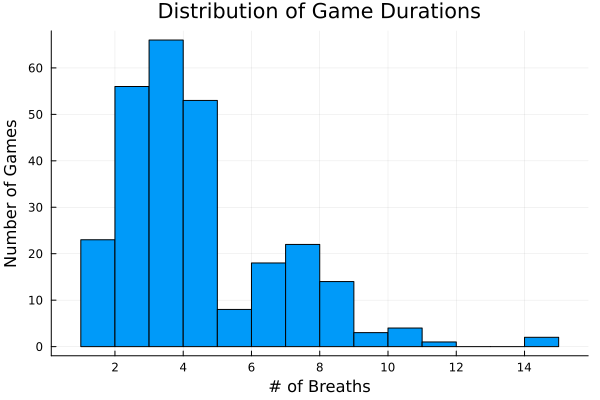

In [113]:
histogram(
    training_games[:,"duration"],
    title="Distribution of Game Durations",
    xlabel="# of Breaths",
    ylabel="Number of Games",
    legend=false
)

Now that we know which games are in the training set, we'll select all the breaths from those games as our training data. Although the training set itself contains all games in which there was at least one human player, we only want to train on human empirical strategies, so we will filter out any breaths that were played by bots.

In [115]:
training_breaths_query = """
SELECT
    training_games.game_id, breaths.state, breaths.action, breaths.is_winner,
    (CASE breaths.is_winner
        WHEN 1 THEN training_games.winner_is_bot
        ELSE training_games.loser_is_bot
    END) as is_bot
FROM ($(training_games_query)) training_games
RIGHT JOIN breaths
    on training_games.game_id = breaths.game_id
WHERE (is_bot=0)
"""
#Use a right join on the `training_games` table to ensure we are only using breaths
#from the training set.

training_breaths = DBInterface.execute(db,training_breaths_query) |> DataFrame
println("""Data contain $(nrow(training_breaths)) breaths.""")
println("""$(length(unique(training_breaths[:,"state"]))) distinct states of $(
    length(STATE_SPACE)) total states visited ($(
    round(100*length(unique(training_breaths[:,"state"]))/length(STATE_SPACE),digits=2)
    )% of state space).""")

Data contain 2130 breaths.
1891 distinct states of 668884 total states visited (0.28% of state space).


As expected; the state space is huge and the player base is small. We are doing our best with limited data here.

Finally, let's examine some statistics of the players who contributed to the training set:

In [142]:
player_wins_query = """
SELECT player_id, username, COUNT(*) as wins
FROM players
RIGHT JOIN games victories
    on players.player_id = victories.winner_id
WHERE (is_bot=0)
AND (victories.game_id<=$(CONFIG["training-cutoff"]))
GROUP BY player_id
"""

player_stats_query = """
SELECT player_id, username, wins, COUNT(*) as losses, 
wins+COUNT(*) as games_played, 1.0*wins/(wins+COUNT(*)) as win_rate
FROM ($(player_wins_query)) player_wins
RIGHT JOIN games losses
    on player_wins.player_id = losses.loser_id
WHERE (losses.game_id<=$(CONFIG["training-cutoff"]))
GROUP BY player_id
"""

player_stats = DBInterface.execute(db,player_stats_query) |> DataFrame

Row,player_id,username,wins,losses,games_played,win_rate
,Int64,String,Int64,Int64,Int64,Float64
1,1,maestro,140,128,268,0.522388
2,2,Handel,71,87,158,0.449367
3,3,Joe,52,48,100,0.52
4,4,Comet,7,7,14,0.5


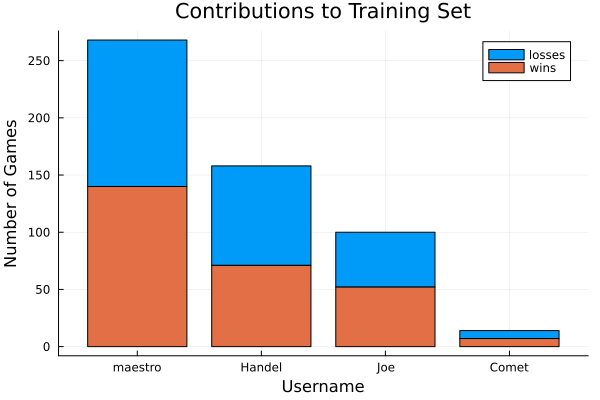

In [157]:
groupedbar(
    [player_stats[:,"losses"] player_stats[:,"wins"]],
    xticks = (1:nrow(player_stats), player_stats[:,"username"]),
    label = ["losses" "wins"],
    bar_position = :stack,
    title = "Contributions to Training Set",
    xlabel = "Username",
    ylabel = "Number of Games"
)

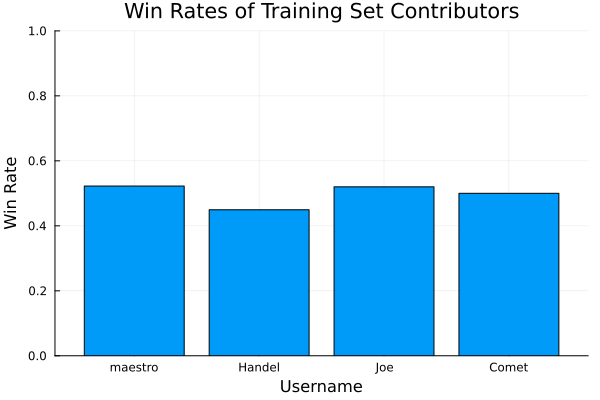

In [158]:
bar(
    player_stats[:,"win_rate"],
    xticks = (1:nrow(player_stats), player_stats[:,"username"]),
    ylims = (0,1),
    title = "Win Rates of Training Set Contributors",
    xlabel = "Username",
    ylabel = "Win Rate",
    legend = false
)

Finally, we will take a look at a scatterplot of games played vs win rate to see if there is any trend. It's possible that veteran players will have a higher win rate. We should expect to see convergence away from extreme win rates as the number of games increases, though.


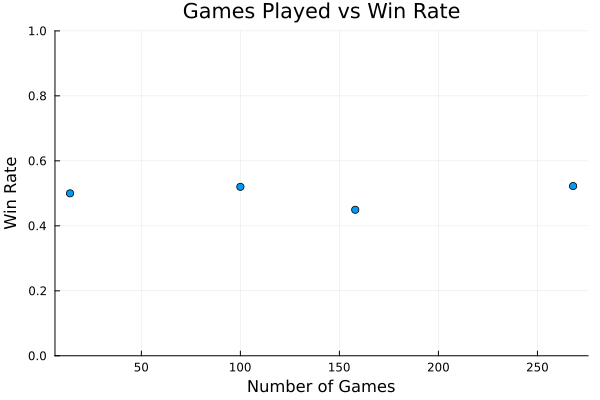

In [159]:
scatter(
    player_stats[:,"games_played"],
    player_stats[:,"win_rate"],
    ylims = (0,1),
    title = "Games Played vs Win Rate",
    xlabel = "Number of Games",
    ylabel = "Win Rate",
    legend = false
)

## Possible Actions Reweighted by Limited Empirical Strategic Samples (PARLESS) <a id="parless"></a>
### [↑ Contents](#contents)

In this section, I present a method for using real game data to reweight the enemy's mixed strategies (i.e. probability distribution over possible actions) which I call **"Possible Actions Reweighted by Limited Empirical Strategic Samples" (PARLESS)**. In this method, we will use the empirical distribution of actions taken from a given state by real players as the "evidence" term in Bayes' rule to reweight the parameters of a categorical/multinomial probability distribution, which we use to represent the mixed strategy. We will use a Dirichlet prior with equal probabilities, as it is the conjugate prior of the multinomial distribution.

Information about Bayesian reweighting with the Dirichlet distribution was obtained from https://en.wikipedia.org/wiki/Dirichlet_distribution.

For each distinct action, let's call it $A_i$, the categorical/multinomial distribution has a parameter $p_i$, which is essentially just the probability of $A_i$ under the distribution. The Dirichlet distribution has a corresponding "concentration" parameter, $\alpha_i$, which is a sort of "pseudocount" of the action $A_i$. 

What does this mean? Essentially, the reweighting process will follow these steps:
1. Assume a prior conjugate distribution with concentration parameters $\alpha_i$ for each action $A_i$. This is effectively equivalent to basing the prior on sample in which $A_i$ occurs $\alpha_i$ times out of $\sum_k\alpha_k$ total observations. 
2. Compute the parameters of the posterior conjugate Dirichlet distribution by incrementing each value of $\alpha_i$ by the number of empirical strategic samples in which $A_i$ was chosen from the given state.
3. Compute the posterior categorical distribution by normalizing the values of $\alpha$ (divide each by the sum).

This procedure is pretty straightforward, however, we have to choose values for the concentration parameters of the prior. Smaller values will result in a more volatile prior, which will result in larger changes in the parameters of the categorical distribution over the actions.

I think it's best to keep things simple and just let all the $\alpha_i=1$. In other words, we will act as if we've seen each possible action used exactly once from a given state. We don't have very much data, so we want to get a big impact out of it; additionally, it's unlikely that we'll have more than one strategic sample from any given state. Overall, I think that this prior will aptly simulate our lack of certainty going into this process.


In [38]:
niv = Dict(enemy_action=>1/length(possible_actions(112011300350011001)) 
                for enemy_action in possible_actions(112011300350011001))

Dict{Int64, Float64} with 8 entries:
  51 => 0.125
  50 => 0.125
  41 => 0.125
  20 => 0.125
  11 => 0.125
  10 => 0.125
  21 => 0.125
  40 => 0.125

## PARLESS Augmented With Neural Networks (PAWNN) <a id="pawnn"></a>
### [↑ Contents](#contents)

PUNISH has a small yet dedicated player base. However, with hundreds of thousands of game states, we simply do not have empirical strategy data for every possible action. However, we may be able to extrapolate from the states that we do have using a deep neural network model. Here, we will experiment with using neural networks trained on the (state ↦ mixed strategy) set generated by the basic PARLESS method to extrapolate mixed strategies for states for which we lack data.

# Enumerating State-Action Transition Probabilities <a id="transitions"></a>
### [↑ Contents](#contents)

Although we have the `transitionmap` function to generate the transition probabilities for any given state-action pair, it will significantly speed up the value iteration algorithm if we pre-compile the transition probabilities.

Note: we will need to generate a separate transition probability map for all three models of enemy strategies (Naïve, PARLESS, and PAWNN).

Before we included intermediary "Breath 5" states, extrapolation from benchmark experiments indicated that generating transition probabilities for each (state,action) pair would take somewhere around 42 hours. With Breath 5 states between non-terminal Breath 4 results and redeals, this computation takes around a half hour.

## Naïve Transition Probabilities <a id="naive-transitions"></a>

This next cell will compute transition probabilities under the Naïve model of enemy strategies, which is just a fancy way of referring to the assumption that the enemy is equally probable to choose any of their possible actions.

In [20]:
if CONFIG["transition-probabilities"]["naive"]["generate"]
    NAIVE_TRANSITIONS = Dict( 
        state => Dict(
            action => transitionmap(state,action) 
            for action in possible_actions(state)
        )
        for state in STATE_SPACE
    )
    open(CONFIG["transition-probabilities"]["naive"]["filepath"],"w") do f
        JSON.print(f,NAIVE_TRANSITIONS)
    end
    #Generate transition map and save results.
else 
    NAIVE_TRANSITIONS = strkeys2int(
        JSON.parsefile(CONFIG["transition-probabilities"]["naive"]["filepath"],use_mmap=false)
    )
    #Load results from disk.
end
println(typeof(NAIVE_TRANSITIONS))

Dict{Int64, Dict{Int64}}


This cell took about 35 minutes to run.

## PARLESS

## PAWNN

# Implementation of Value Iteration <a id="value-iteration"></a>
### [↑ Contents](#contents)

In this section, we will implement the value iteration algorithm  (and its accessory functions), which we will use to train our agents. Value iteration is an offline reinforcement learning algorithm which applies dynamic programming to an MDP-representation of a game to generate a "state-action value" function (also known as a Q-function), which assigns relative values to taking a given action from a given state for every possible (state,action) pairing. [This video](https://youtu.be/4KGC_3GWuPY) does an excellent job showing how the algorithm works.

Reinforcement learning algorithms require a state-action reward function, which assigns quantitative rewards to each (state,action) pair. If we want to incentivize certain kinds of gameplay, we might customize the values in these functions. However, we will just stick with the basic state-action reward function, in which the reward for taking some action at a given state is just the expected value of the state-rewards of all the successors of that action (i.e. the sum of the state rewards of the successors, weighted by their probabilities of resulting from the action). 

We will also keep our state reward function pretty simple: a WinState is +1, a LossState is -1, and any DuelingState is 0. If we wanted to incentivize the agent to keep games quick (i.e. penalize it for dragging the game out), we might assign a slight negative value to DuelingStates, but I believe that the inherent risk of playing the game is enough of a driving force to keep things short and sweet.

In [21]:
function state_reward(s::Int)
    return get(Dict(-2=>-1.0,-1=>+1.0),s,0.0)
    #Faster than wasting time decoding the state.
    #Note: values must be specified as floats or else
    #nested dicts in the Q-function may assume values to be
    #integers.
end

function state_action_reward(state::Int,action::Int,transition_probabilities::Dict)
    """This function returns the immediate expected reward of a (state,action) pair, 
    calculated as the probability-weighted sum of the state-rewards of the possible
    successor states."""
    return sum([p*state_reward(successor) for (successor,p) in transition_probabilities[state][action]])
end

state_action_reward (generic function with 1 method)

We will initialize the blank state-action function such that the value of any given (state,action) pair is equal to the immediate expected state-action reward, as defined in the previous cell.

In [22]:
function initialize_Q_function(transition_probabilities)
    """This function initializes a state-action value function
    such that each (state,action) pair maps to its immediate expected reward."""
    Q_function = Dict(
        state => Dict(
            action => state_action_reward(state,action,transition_probabilities)
            for action in keys(transitions)
        )
        for (state,transitions) in transition_probabilities
    )
end

initialize_Q_function (generic function with 1 method)

Now, we have all the pieces we need to implement value iteration. The value iteration algorithm itself is pretty simple. It really consists of two basic steps:

1. Compute the "state-value" function (also known as the V-function) which assigns values to states themselves rather than (state,action) pairs. The value assigned is simply the Q-function value resulting from taking the optimal action (i.e. argmax of the Q-function for that state) from that state.
2. Update the Q-function; the new value of a given (state,action) pair is equal to the immediate state-action reward plus the "discounted" (scaled by $0<\gamma<1$) probability-weighted sum of the successors' V-function values.

In [28]:
function value_iteration!(Q_function::Dict,transition_probabilities::Dict;discount=0.95) 
    """This function performs a single training episode of value iteration on a given Q-function
    dictionary, based on an input transition probability map.
    
    Note: this function mutates the `Q_function` argument."""
    greedy_choice = (state -> argmax(Q_function[state]))
    #Use a greedy policy, in which we choose the action with the highest state-action value for the
    #given state.
    V_function = Dict(state => Q_function[state][greedy_choice(state)] for state in STATE_SPACE)
    #The state-value function assigns each state the value resulting from taking the 
    #optimal action from that state.

    for (state, action_maps) in transition_probabilities
        for (action, successors) in action_maps
            immediate_reward = state_action_reward(state,action,transition_probabilities)
            successor_rewards = sum([p*V_function[successor] for (successor,p) in successors])
            Q_function[state][action] = immediate_reward + discount*successor_rewards
            #Update each value of the Q-function so that it is equal to the immediate
            #state-action reward plus the discounted sum of the state-values
            #of the immediate successor states, weighted by their transition probabilities.
        end
    end
    return Q_function
                     
end

value_iteration! (generic function with 1 method)

Finally, we will need to create a function to measure the change between two Q-functions so that we can measure the convergence of our training. We will do this by computing the root-mean-square error over all possible (state,action) pairs between two Q-functions.

In [24]:
function Q_function_error(Q1::Dict,Q2::Dict)
    """This function computes the RMSE over all
    (state,action) pairs between two Q-functions."""
    err = 0
    for (state,actions) in Q1
        for (action,value) in actions
            err += (Q1[state][action] - Q2[state][action])^2
            #Sum the squared errors for every (state,action) pair.
        end
    end
    return sqrt(err)
end

Q_function_error (generic function with 1 method)

# Agent Training <a id="training"></a>
### [↑ Contents](#contents)

In this section, we will apply value iteration to train our agents. We will design this Notebook such that if a specified number of training episodes is found to be insufficient, we can pick up where we left off rather than starting training over from scratch.

## Naïve Agent <a id="naive-agent"></a>

In [25]:
if CONFIG["value-iteration"]["naive"]["generate"]
    Q_Naive = initialize_Q_function(NAIVE_TRANSITIONS)
    #If generating from scratch, initialize the Q-function with 
    #immediate expected rewards.
    training_log["naive"] = []
else 
    Q_Naive = strkeys2int(
        JSON.parsefile(CONFIG["value-iteration"]["naive"]["filepath"],use_mmap=false)
    )
end

Dict{Int64, Dict{Int64, Float64}} with 668884 entries:
  310200300330123030 => Dict(11=>-0.952812, 10=>12.4745, 31=>-1.15578, 30=>13.5…
  511001300210021222 => Dict(90=>15.0316)
  210300301140121022 => Dict(10=>5.31734, 30=>12.9174)
  102012300350000300 => Dict(51=>11.1003, 50=>15.6902, 41=>10.4096, 21=>11.4714…
  401020201220131213 => Dict(20=>13.3267, 40=>14.9711)
  301110301330130222 => Dict(20=>-5.0521, 30=>5.42679, 40=>-1.55826)
  300111300331122202 => Dict(51=>15.0781, 50=>19.8875, 41=>18.8875, 31=>18.8875…
  300111211331023012 => Dict(90=>11.7682)
  201210301340112121 => Dict(20=>-4.2145, 30=>7.01121, 40=>-4.33004)
  300111110131103122 => Dict(90=>17.4737)
  210003200240010130 => Dict(51=>12.7017, 50=>16.3388, 11=>11.1431, 10=>14.653)
  220011200140010112 => Dict(51=>14.9706, 50=>6.04144, 41=>13.4759, 11=>14.5631…
  401100201330032211 => Dict(20=>-19.8875, 30=>9.10219)
  300111200130132021 => Dict(51=>18.1634, 50=>11.8258, 41=>16.9036, 31=>18.0665…
  301011100130111222 => Dict(5

In [32]:
for i in (1:CONFIG["value-iteration"]["naive"]["episodes"]).+length(training_log["naive"])
    #Start training from the next episode over the last one logged.
    Q_Naive_old = deepcopy(Q_Naive)
    #Copy the current Q-function before training for comparison. 
    Q_Naive = value_iteration!(Q_Naive,NAIVE_TRANSITIONS)
    #Run one episode of value iteration.
    err = Q_function_error(Q_Naive,Q_Naive_old)
    #Compute the RMSE for the before and after Q-functions to
    #check convergence.
    push!(training_log["naive"],err)
    #Record the RMSE value in the log.
    println("Episode $(i): RMSE=$(err)")
end

Episode 101: RMSE=5.35349066338031
Episode 102: RMSE=5.085831529477704
Episode 103: RMSE=4.831545750031296
Episode 104: RMSE=4.589975301251026
Episode 105: RMSE=4.360494400860289
Episode 106: RMSE=4.142502842483667
Episode 107: RMSE=3.9353987138951454
Episode 108: RMSE=3.7386369725225195
Episode 109: RMSE=3.551706974497102
Episode 110: RMSE=3.3741245156234045
Episode 111: RMSE=3.205423230547698
Episode 112: RMSE=3.0451556966146307
Episode 113: RMSE=2.892901366661692
Episode 114: RMSE=2.7482614103752026
Episode 115: RMSE=2.6108518261912987
Episode 116: RMSE=2.480311304589201
Episode 117: RMSE=2.3562968651385603
Episode 118: RMSE=2.2384826828463544
Episode 119: RMSE=2.126559037979792
Episode 120: RMSE=2.0202316300885625
Episode 121: RMSE=1.9192205620544929
Episode 122: RMSE=1.8232597609562056
Episode 123: RMSE=1.732096940797657
Episode 124: RMSE=1.6454924158456163
Episode 125: RMSE=1.5632183619595168


In [33]:
if CONFIG["value-iteration"]["naive"]["episodes"] > 0
    open(CONFIG["value-iteration"]["naive"]["filepath"],"w") do f
        JSON.print(f,Q_Naive)
    end
    open("training_log.json","w") do f
        JSON.print(f,training_log)
    end
    #If training was performed, save the trained Q-function and the
    #logged RMSE values.
end

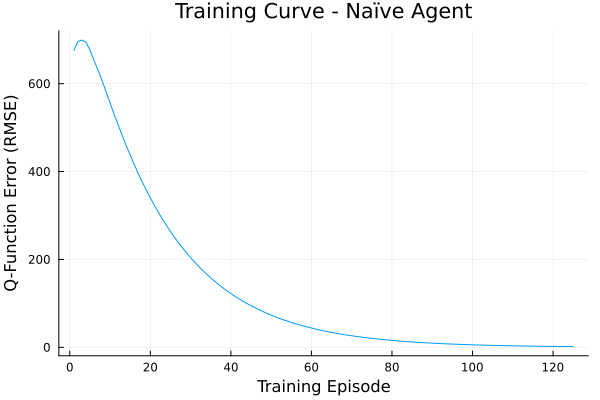

In [39]:
plot(
    1:length(training_log["naive"]),training_log["naive"],
    legend=false,
    title="Training Curve - Naïve Agent",
    xlabel="Training Episode",
    ylabel="Q-Function Error (RMSE)"
)

# Analysis <a id="analysis"></a>
### [↑ Contents](#contents)